# Week 3 Day 2 

## Spatial Regression

Now that we know how to run linear regressions, let's go into spatial regressions. 

In [1]:
from pysal.lib import weights
import esda
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn
import contextily as ctx

import params
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

In [2]:
import os
path = os.getcwd()

In [3]:
## Bring in the same data sets from yesterday 

cali = pd.read_excel(path + '/cali.xlsx')
zip = gpd.read_file(path + '/ZipCodes.zip')
risk = pd.read_excel(path + '/Wildfire_2021.xlsx', sheet_name = '2021HO')
insurance = pd.read_excel(path + '/insurance.xlsx')

In [4]:
zip['ZIP_CODE'] = zip['ZIP_CODE'].astype(int)
cali = cali[['ZIP', 'Education', 'Poverty', 'Unemployment',  'Housing Burden', 'Linguistic Isolation', 'Ozone', 'PM2.5']]
cali= cali.groupby(by ='ZIP').mean()
zip_cali = zip.merge(cali, left_on = 'ZIP_CODE', right_on = 'ZIP')


risk = risk[['ZIP Code', 'Avg Fire Risk Score', 'Number of Negligible Fire Risk Exposure',
       'Number of Low Fire Risk Exposure',
       'Number of Moderate Fire Risk Exposure',
       'Number of High Fire Risk Exposure',
       'Number of Very High Fire Risk Exposure', 'Earned Premium']]
calirisk = zip_cali.merge(risk, left_on = 'ZIP_CODE', right_on = 'ZIP Code')

insurance = insurance[insurance['Year']==2020]
df_f = pd.merge(calirisk, insurance, left_on = 'ZIP Code', right_on = 'ZIP Code')

In [5]:
df = gpd.GeoDataFrame(
    df_f, 
    geometry = 'geometry',
    crs = "EPSG:3857")

In [6]:
df['urban'] = 1*(df['POP_SQMI']>1000)
df[['urban']]

,urban
0,1
1,1
2,1
3,1
4,1
...,...
1334,0
1335,0
1336,0
1337,0


### Brief Review of Linear Regressions

In [7]:
## let's rename some variables again 

df= df.rename(columns = {
    'Number of Very High Fire Risk Exposure': 'Very_High', 
    'Avg Fire Risk Score': 'Avg_Risk',
    'Earned Premium': 'Earned_Prem',
    'Housing Burden': 'Hous_Burd',
    'Insurer-Initiated Nonrenewed' : 'Insurer_Nonrenewed',
    'Insured-Initiated Nonrenewed': 'Insured_Nonrenewed',
    'PM2.5' : 'PM25',
    'Linguistic Isolation': 'Ling_Iso'
})

In [8]:
df.shape

(1339, 29)

In [9]:
df= df.dropna()

In [27]:
df.reset_index()

(1282, 29)

In [11]:
## type a multivariate regression like the one we learned yesterday 

mvr = smf.ols(formula = 'Insurer_Nonrenewed ~ Avg_Risk + POP_SQMI + Hous_Burd + Education + Poverty', 
              data =df).fit()

mvr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Insurer_Nonrenewed   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     8.061
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           1.69e-07
Time:                        07:32:29   Log-Likelihood:                -8052.0
No. Observations:                1282   AIC:                         1.612e+04
Df Residuals:                    1276   BIC:                         1.615e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    125.0501     13.649      9.162      0.000      98.272     151.828
Avg_Risk      17.4425      6.400      2.725      0.007       4.886      29.998
POP_SQMI      -0.0032      0.001     -4.609      0.000      -0.005      -0.002
Hous_Burd      2.1375      0.868      2.464      0.014       0.435       3.840
Education      1.4960      0.497      3.008      0.003       0.520       2.472
Poverty       -1.5465      0.449     -3.444      0.001      -2.428      -0.665
==============================================================================
Omnibus:                      713.402   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6844.460
Skew:                           2.424   Prob(JB):                         0.00
Kurtosis:                      13.229   Cond. No.                     2.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Other Ways to Run Linear Regressions

In [12]:
var_main = ['Avg_Risk', 'POP_SQMI', 'Hous_Burd']
var_con = ["Avg_Risk", "POP_SQMI", "Hous_Burd", "Education", "Poverty", "Unemployment"]
var_extend =["Avg_Risk", "POP_SQMI", "Hous_Burd", "Education", "Poverty", "Unemployment", 'Ling_Iso', 'Ozone', 'PM25']

var_dep = ['Insurer_Nonrenewed']

## create your own varialbe list so that you can use it through out the class exercises 
## include 6 variables in the list: 3 main variables of interest and 3 controls 


In [21]:
## other ways to run regressions?
from pysal.model import spreg

#Basic regression with only the main independent variables
ols_main = spreg.OLS(
    #Dependent Variable:
    df[['Insurer_Nonrenewed']].values,
    #Independent Variable:
    df[var_main].values,
    #Dependent Variable Names
    name_y= 'Insurer Initiated Nonrenewals',
    #Independent Variable Names
    name_x = var_main,
    #specify robust standard errors
    robust = 'white',
)

In [22]:
ols_main

In [23]:
print(ols_main.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Insurer Initiated Nonrenewals                Number of Observations:        1282
Mean dependent var  :    137.9072                Number of Variables   :           4
S.D. dependent var  :    131.3436                Degrees of Freedom    :        1278
R-squared           :      0.0213
Adjusted R-squared  :      0.0190
Sum squared residual: 2.16289e+07                F-statistic           :      9.2527
Sigma-square        :   16924.042                Prob(F-statistic)     :   4.689e-06
S.E. of regression  :     130.092                Log likelihood        :   -8058.166
Sigma-square ML     :   16871.236                Akaike info criterion :   16124.333
S.E of regression ML:    129.8893                Schwarz criterion     :   16144.958

White Standard Errors
---------------------

In [ ]:
## What if we wanted to run the extended list of independent variables?

#Basic regression with only the main independent variables
ols_ext = spreg.OLS(
    #Dependent Variable:

    #Independent Variable:

    #Dependent Variable Names

    #Independent Variable Names

    #specify robust standard errors

)

In [ ]:
print(ols_ext.summary)

In [ ]:
## 'spreg' package has a slightly different code to figure out the r-squared

ols_ext.r2

In [ ]:
## the 'spreg' function from pysal allows us to get the results of the error term very easily. 
## let's save the residuals in a separate column in the data frame

df['resid_ols'] = ols_ext.u
df[['resid_ols']]

In [ ]:
## Try running a regressoin with the variable list that you created 



In [ ]:
df.crs

In [ ]:
## what happens when we plot the residual results onto a map

fig = plt.figure(figsize=(16,9))
ax=plt.subplot()

df.plot(
    column = 'resid_ols',
    cmap = 'coolwarm',
    edgecolor = 'k',
    linewidth = 0.2,
    ax=ax
)

zip.plot(
    ax=ax,
    alpha = 0.5,
    color = 'none',
    edgecolor = 'k',
    linewidth = 0.2
)

In [ ]:
## let's create some weights 

w6 = weights.KNN.from_dataframe(df, k=6)
w6.transform = "R"
w8 = weights.KNN.from_dataframe(df, k=8)
w8.transform = "R"

In [ ]:
## what if we were to lag the residuals to see any patterns of clustering among the error terms 

resid_lag = weights.spatial_lag.lag_spatial(w6, ols_ext.u)

ax = seaborn.regplot(
    x= ols_ext.u.flatten(),
    y = resid_lag.flatten(),
    line_kws = dict(color = "orangered"),
    scatter_kws={'alpha' : 0.3, 's' : 10},
    ci = None,
)

ax.set_xlabel('OLS Residuals - $u$')
ax.set_ylabel('Spatial Lag OLS Residuals - $Wu$')

In [ ]:
## let's look at the Moran's I value and the p-value 

moran_ols_resid = esda.moran.Moran(df['resid_ols'], w6)
print(moran_ols_resid.I)
print(moran_ols_resid.p_sim)

In [ ]:
## what if we wanted to make a LISA map for insurance companies pulling out and also the residuals?

## make the lagged version for residuals
df['resid_ols_lag'] = (df['resid_ols']- df['resid_ols'].mean())/ df['resid_ols'].std()


In [ ]:
## create the lisa variables for Insurer_Nonrenewed and the residuals

lisa_ins = esda.moran.Moran_Local(df["Insurer_Nonrenewed"], w6)
lisa_res = esda.moran.Moran_Local(df['resid_ols'], w6)

In [ ]:
## plot the LISA map 
from splot import esda as esdaplot

fig, ax = plt.subplots(1, 2, figsize=(12,12,))

## first plotting the Insurer Nonrenewed
esdaplot.lisa_cluster(lisa_ins, df, p=0.05, ax=ax[0])
zip.plot(alpha =0.5, color = 'none', edgecolor = 'k', linewidth = 0.4, ax=ax[0])

## next, plotting the residuals 
esdaplot.lisa_cluster(lisa_res, df, p=0.05, ax=ax[1])
zip.plot(alpha =0.5, color = 'none', edgecolor = 'k', linewidth = 0.4, ax=ax[1])

## naming the maps 
ax[0].set_title('LISA Map for Insurer-Initiated Nonrenewals')
ax[1].set_title('LISA Map for OLS Residuals')



A low Moran's I value among the residual terms would indicate that a lot of the variance within the regression is captured by the explanatory variables. If we included all the necessary variables, but still see a high Moran's I in the residuals, that would indicate that there are other phenomena going on that are affecting the dependent variable. In spatial analysis, we suggest that high Moran's I implies spatial patterns that are not captured by the linear regression 

## Diagnostics for Spatial Regressions

In [ ]:
ols_ext_sp = spreg.OLS(
    #Dependent Variable:
    df[['Insurer_Nonrenewed']].values,
    #Independent Variable:
    df[["Avg_Risk", "POP_SQMI", "Hous_Burd", "Education", "Poverty", "Unemployment", 'Ling_Iso', 'Ozone', 'PM25']].values,
    #Dependent Variable Names
    name_y = 'Insurer Nonrenewals',
    #Independent Variable Names
    name_x = var_extend,
    #specify robust standard errors
    robust = 'white',
    #specify weights
    w= w8,
    #print out spatial diagnostics
    spat_diag = True
)

In [ ]:
print(ols_ext_sp.summary)

In [ ]:
## VIF test

testresult = spreg.diagnostics.vif(ols_ext)

In [ ]:
avgrisk_vif = testresult[1]
print("%8.8f"%avgrisk_vif[0])

Based on the diagnostics test that we saw as below, what can we say about the model of best fit?
</figure>
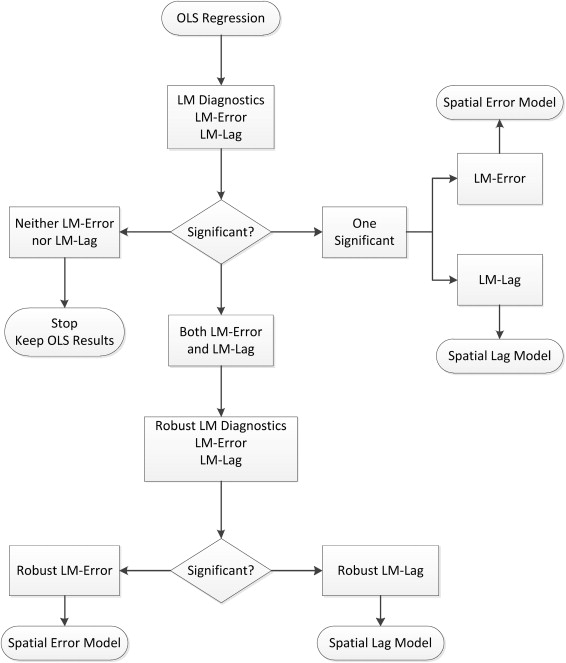

### Spatial Fixed Effects
Just like in the case where we would run linear fixed effect regressions, we could also do that spatially. The spatial fixed effect is particularly useful when we have a linear regression with a categorical variable. 
Fixed effects allows us to account for different neighborhoods/ regions/ spatial clusters, and basically run different regressions for each geographic area.
By holding all other variables constant, the spatial fixed effect allows for greater degrees of isolation. In otherwords, instead of assuming the dependent variable behaves uniformly over space, there are systematic effects following a geographical pattern that affect its behavior. 


In [ ]:
sfe = spreg.OLS_Regimes(
    #Dependent Variable
    df[["Insurer_Nonrenewed"]].values,
    # Independent Variable
    df[var_extend].values,
    # Variable specifying neighborhood membership
    df['urban'].tolist(),
    # Allow constant term to vary by group/regime 
    constant_regi = "many",
    # Variables to be allowed to vary (True), or kept constant (False)
    cols2regi= [True] * len(var_extend),
    # Allow separate sigma coefficients to be estimated by regime
    regime_err_sep = False,
    # Dependent Variable Name\
    name_y = "Insurer Nonrenewals",
    # Independent variable names
    name_x = var_extend,
)

In [ ]:
print(sfe.summary)

In [ ]:
ols = smf.ols(formula = 'Insurer_Nonrenewed ~ Avg_Risk + POP_SQMI + Hous_Burd + Education + Poverty + Unemployment + Ling_Iso + Ozone + PM25', 
              data =df).fit()


### SLX Model - Spatially Lagged X Model - Spatially Lagged Exogenous Variable


$$
(InsurerNonrenewals_i) = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon
$$

This is basically adding lagged X variables into the regression

In [ ]:
df.head()

In [ ]:
## make a loop to create spatially weighted varaibles 
var_lag = df[var_extend].apply(lambda y: weights.spatial_lag.lag_spatial(w6, y))

var_lag = var_lag.rename(columns = lambda c: "W_"+c)

In [ ]:
## join the two variable lists together 

var_slx = df[var_extend].join(var_lag)

In [ ]:
## write out the equation for the SLX regression

slx = spreg.OLS(
    # Dependent Variable
    df[['Insurer_Nonrenewed']].values,
    # Independent Variable
    var_slx.values,
    # Dependent Variable Name 
    name_y= "Insurer Nonrenewals",
    # Independent Variable Names
    name_x= var_slx.columns.tolist(),
)

In [ ]:
slx.betas

In [ ]:
slx.std_err

In [ ]:
print(slx.summary)

In [ ]:
## can we make that into a data frame?

pd.DataFrame(
    {
        ## Pull out regression coefficients and standard errors and flatten to NX1 array 
        "Coeff": slx.betas.flatten(),
        "Std. Error": slx.std_err.flatten(),
        "P-Value": [i[1] for i in slx.t_stat],
    },
    index=slx.name_x
)

In [ ]:
### with the variables that you are interested in, try creating dataframe for the SLX results 



### SLM (Spatial Lag Model) - Lagged Y variable - Spatially Lagged Exogenous Variable

$$
{InsurerNonrenewals_i} = \alpha + \rho {InsurerNonrenewals_{lag-i}} + \sum_k \beta_k X_{ki} + \epsilon_i
$$

In [ ]:
## write the equation for the SLM 

slm = spreg.GM_Lag(
    df[['Insurer_Nonrenewed']].values,
    df[var_extend].values,
    w= w6,
    name_y = "Insurer Initiated Nonrenewals",
    name_x= var_extend,
)

In [ ]:
## print out the summary statistic

print(slm.summary)

In [ ]:
## what if we wanted to create a dataframe with the information on coeff, std error and p-value?

pd.DataFrame(
    {
    "Coeff.": slm.betas.flatten(),
    "Std. Error": slm.std_err.flatten(),
    "p-value": [i[1] for i in slm.z_stat],
    },
    index = slm.name_z,

).round(4)


In [ ]:
## With the list of variables that you are interested in, try creating a SLM model result dataframe

### SEM (Spatial Error Model) - Lagged $u$ variable

$$
{InsurerNonrenewals_i} = \alpha + \sum_k \beta_k X_{ki} + u_i
$$

$$
u_i = \lambda u_{lag-i} + \epsilon_i
$$

where $u_{lag-i} = \sum_j w_{i,j} u_j$. 

In [ ]:
## write codes for SEM 

sem = spreg.GM_Error_Het(
    df[['Insurer_Nonrenewed']].values,
    df[var_extend].values,
    w=w6,
    name_y = "Insurer Initiated Nonrenewals",
    name_x = var_extend
)


In [ ]:
## print out the results

print(sem.summary)

In [ ]:
## what if we wanted to create a dataframe with the information on coeff, std error and p-value?

pd.DataFrame(
    {
    "Coeff.": sem.betas.flatten(),
    "Std. Error": sem.std_err.flatten(),
    "p-value": [i[1] for i in sem.z_stat],
    },
    index = sem.name_x,

).reindex(['lambda']).round(4)


### Diagnostics 

In [ ]:
## Lower Values for the Bayesian Information Criteria is better 

slx_res = spreg.schwarz(slx)
slm_res = spreg.schwarz(slm)

print( slx_res, slm_res)